In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pingouin as pg
import pandahouse as ph
from tqdm.auto import tqdm

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Task 1: A/B testing

While testing one hypothesis the target group was offered a new payment mechanics on the website while the control group was left with the basic mechanics. The task is to analyze the results of the experiment and conclude whether the new payment mechanics should be run on all users.

We suggest you answer the following questions:

What metrics are you looking at in your analysis and why? 
Are there differences in the metrics and what might they be related to? 
Are the differences statistically significant? 
Is it worth running the new mechanics on all users?

We have 4 csv files as input:

groups.csv - file with information about user's membership in control or experimental group (A - control, B - target group)

groups_add.csv - an extra file with users that was sent to you 2 days after the data was transferred

active_studs.csv - file with information about users who logged in to the platform on the days of the experiment.

checks.csv - file with information about users' payments on the days of the experiment.

In [3]:
# Loading the data
active = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-se/Final_Project/project2/Проект_2_active_studs.csv')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-se/Final_Project/project2/Проект_2_checks.csv', sep=';')
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-se/Final_Project/project2/Проект_2_groups.csv', sep=';')

# This table will be used in the last task
# add = pd.read_csv('Проект_2_group_add.csv')

Let's see what the data looks like. Rename the necessary columns.

In [4]:
active = active.rename(columns={'student_id': 'id'})
# We can conclude that each user made just one purchase on the days of the experiment 
# (541 checks and 541 unique buyers in the table)
checks = checks.rename(columns={'student_id': 'id'})
checks.shape
checks.id.nunique()

541

In [5]:
# Compile a table with payments from active users
active_checks = active.merge(checks, how='left', on='id')
active_checks.rev = active_checks.rev.fillna(0)
# 8341 rows × 2 columns
active_checks.head()

,id,rev
0,581585,0.0
1,5723133,0.0
2,3276743,0.0
3,4238589,0.0
4,4475369,0.0


We look at how many of the active users made a purchase. There are more actual purchases than active users (541 payments, though only 392 payments from those who visited on the days of the experiment). Plus we know that everyone made only one purchase. Total of __149__ payments not taken into account in the experiment on the days of the experiment.

! It is possible that they were not counted as active, and this could affect the conclusions of the experiment. Or are these users with a subscription.

In [6]:
paid_users = active_checks.query('rev>0').groupby('id', as_index=False).agg({'rev': 'sum'})
paid_users.shape

(392, 2)

In [8]:
# 13 active users have no breakdown by group. One of them is a paying user.
lost = active_checks.merge(groups, how='outer', on='id')
lost.grp = lost.grp.fillna(0)
lost.query('grp==0')

,id,rev,grp
1,5723133,0.0,0
111,5951797,0.0,0
632,5730382,0.0,0
2662,5739944,0.0,0
3830,5945085,0.0,0
4900,5700613,0.0,0
5254,5729371,0.0,0
5746,5777081,0.0,0
7413,5740903,1900.0,0
7505,5760471,0.0,0


In [10]:
# Select the active participants from the grouping table (groups).
exp = groups.query('id in @active_checks.id')
# 8328 rows × 2 columns
# 13 active users have no breakdown by group. One of them is a paying user.

# Now merge the resulting active_checks table with the prepared table with active users' payment information (active_checks).
full = exp.merge(active_checks, how='left', on='id')
# 8328 rows × 3 columns
full.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


We are testing a new payment system and will be looking at user-to-customer conversion and revenue figures:
- ARPPU (Revenue/Customers)
- ARPU (Revenue/Users).

There is simply not enough data for the other metrics.

In [12]:
# How many active members are in each group
ab = full.groupby('grp', as_index=False).agg({'id': 'count'}).round(2)

# How many active members in each group made a purchase
ab['paid'] = full.query('rev>0').groupby('grp', as_index=False).agg({'id': 'count'}).id

# What is the conversion from active member to buyer
ab['cr'] = (full.query('rev >0').groupby('grp', as_index=False).agg({'id': 'count'}).id / ab.id * 100).round(2)

# Average revenue per paying user (here average check)
ab['ARPPU'] = (full.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev / ab.paid).round(0)

# Average income per active user
ab['ARPU'] = full.groupby('grp', as_index=False).agg({'rev': 'mean'}).rev.round(0)

ab

,grp,id,paid,cr,ARPPU,ARPU
0,A,1535,78,5.08,934.0,47.0
1,B,6793,313,4.61,1256.0,58.0


- Group B has higher ARPPU and ARPU compared to the control group.
- Group A has higher conversion to purchase.

In order to check the statistical significance of these differences between the groups, a number of statistical tests will be conducted. But first we need to check the distribution of the data in the groups.

First we look at the data on __all active users__ of the experiment (both paying and non-paying users).

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


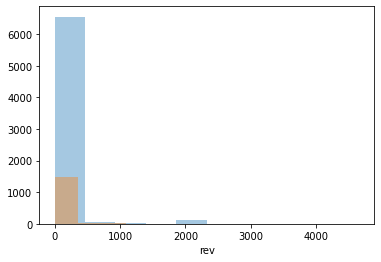

In [13]:
# Make sure that the revenue distribution is different from normal
sns.distplot(full[full.grp == 'B'].rev, bins=10, kde=False)
sns.distplot(full[full.grp == 'A'].rev, bins=10, kde=False)

In [14]:
# use pingouin to test the normality of the group distribution

pg.normality(data=full, dv="rev", group="grp", method="normaltest")

# the data in the groups is not normally distributed

,W,pval,normal
A,2235.003893,0.0,False
B,7799.583992,0.0,False


In [15]:
# Let's use the bootstrap as a more appropriate method under these conditions: 
# a large difference in the number of subjects between the groups and a non-normal distribution
# Declare a function that will allow hypothesis testing using the bootstrap

def get_bootstrap(
    data_column_1,  # numerical values of the first sample
    data_column_2,  # numerical values of the second sample
    boot_it = 10000,  # number of bootstrap subsamples
    statistic = np.mean,  # statistic of interest
    bootstrap_conf_level = 0.95  # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True  # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))  # mean() - apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualisation
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

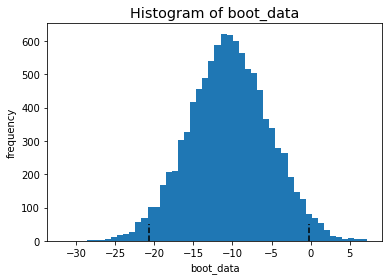

In [16]:
booted_data_mean_full = get_bootstrap(
    full.query('grp == "A"').rev,  # numerical values of the first sample
    full.query('grp == "B"').rev,  # numerical values# number of bootstrap subsamples of the second sample
    boot_it = 10000,  # number of bootstrap subsamples
    statistic = np.mean, # statistic of interest
    bootstrap_conf_level = 0.95  # significance level
)

In [17]:
booted_data_mean_full["p_value"]

0.04429980180197975

In [18]:
booted_data_mean_full["ci"]

,0
0.025,-20.612168
0.975,-0.240553


The bootstrap test showed a p-value <0.05, and the confidence interval for the difference in the mean does not include zero, so we reject the null hypothesis. The test and control sample for all active users of the experiment (both paying and non-paying) have differences.

Now look at the data for all __active paying__ users in the experiment.

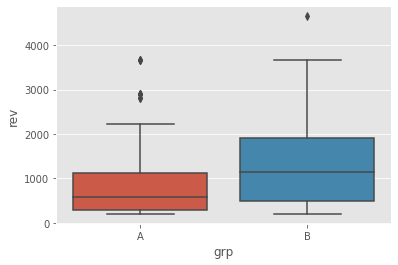

In [19]:
paid = full.query('rev>0')
sns.boxplot(x="grp", y="rev", data=paid)
# boxplot shows basic statistics of the data samples. Outliers are present in both groups.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


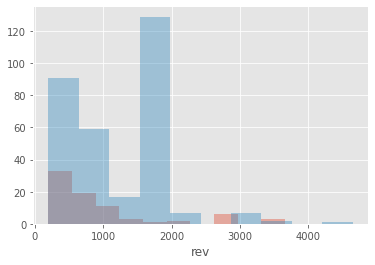

In [20]:
# Make sure that the revenue distribution is different from normal

sns.distplot(paid[paid.grp == 'A'].rev, bins=10, kde=False)
sns.distplot(paid[paid.grp == 'B'].rev, bins=10, kde=False)

# Group B has an abnormally high number of customers with a purchase of 1,900 c.u.

In [22]:
# use pingouin to test the normality of the group distribution

pg.normality(data=paid, dv="rev", group="grp", method="normaltest")

# the data in the groups is not normally distributed

,W,pval,normal
A,30.37842,2.531687e-07,False
B,7.02227,2.986301e-02,False


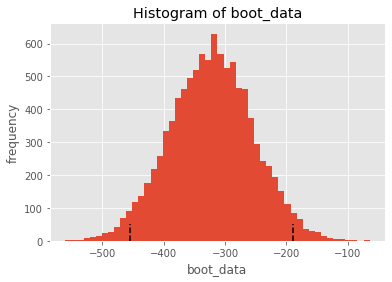

In [25]:
# Use the bootstrap to see how the difference between the means is distributed
# for control and test groups among paying users.

booted_data_mean_paid = get_bootstrap(
    paid.query('grp == "A"').rev,  # numerical values of the first sample
    paid.query('grp == "B"').rev,  # numerical values# number of bootstrap subsamples of the second sample
    boot_it = 10000,  # number of bootstrap subsamples
    statistic = np.mean, # statistic of interest
    bootstrap_conf_level = 0.95  # significance level
)

In [26]:
booted_data_mean_paid["p_value"]

2.239679212985711e-06

In [27]:
booted_data_mean_paid["ci"]

,0
0.025,-455.598814
0.975,-188.889550


The bootstrap test showed a p-value < 0.05, and the confidence interval for the means' difference does not include zero, so we reject the null hypothesis. The test and control sample for __active paying__ users have statistically significant differences.

Now we need to establish whether the difference in conversions (CR) between the groups is statistically significant. To do this, apply Pearson's chi-square test to test the independence of the categorical variables.

In [33]:
# Add a column where 1 means the user has made a purchase and 0 means the user has not made a purchase.
full['customer'] = full.rev.apply(lambda x: 1 if x > 0 else 0)
full.head()

,id,grp,rev,customer
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


In [34]:
# Create a summary or contingency table
full_chi2 = pd.crosstab(full.grp, full.customer)
full_chi2

customer,0,1
grp,,
A,1457,78
B,6480,313


In [35]:
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(full_chi2)

alpha = 0.05
if p <= alpha:
   print ( 'Dependent (reject H0)' )
else :
    print ( 'Independent (H0 holds true)' )

Independent (H0 holds true)


In [36]:
p

0.46803677583199144

p-value > 0.05, and we accept the null hypothesis that being a member of one group or another has no effect on the number of purchases made.

In [37]:
# Ones again our metrics
ab

,grp,id,paid,cr,ARPPU,ARPU
0,A,1535,78,5.08,934.0,47.0
1,B,6793,313,4.61,1256.0,58.0


- The test sample has large outliers, this greatly distorts our mean.
- The bootstrap with an estimate of the mean of all _active users_ showed a p-value < 0.05, we could reject the null hypothesis of equality of means and conclude that the test sample and the control sample of all active users have differences (__metric ARPU__)
- The bootstrap estimation of the mean of all _paying_ users showed a p-value < 0.05. We could reject the null hypothesis of equality of means and conclude that the test sample and the control sample of all paying users have differences (__metric ARPPU__).
- No statistically significant differences were found between test and control group conversions to purchase (__metric CR__).

__Conclusion__: The average revenue per paying user and average revenue per active user is higher in group B, and this difference is statistically significant. The decrease in conversion in the test group is not statistically significant. The metrics tell us that the new payment mechanics can be run on all users.  

In case the experiment will be repeated, there are some details to keep in mind:
- a relatively equal number of subjects in the control and test groups, 
- check the nature of the "anomaly" (where group B has purchases of 1900 c.u.), 
- assign the groups to all active participants (there are now 13 people without groups),
- find out how the cheque could get into the experiment table if this participant was not active.

# Task 2.

Implement a function that will automatically load information from an additional __groups_add.csv__ file and recalculate metrics based on additional parameters.

In [38]:
file_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-se/Final_Project/project2/Проект_2_group_add.csv'

def import_data(file_path):
    groups_full = groups.append(pd.read_csv(file_path, sep = ','))
    df_update = active.merge(checks, how='left', on='id')
    df_update.rev = df_update.rev.fillna(0)
    exp_update = groups_full.query('id in @df_update.id')
    full_update = exp_update.merge(df_update, how='left', on='id')
    ab_update = full_update.groupby('grp', as_index=False).agg({'id': 'count'}).round(2)
    ab_update['paid'] = full_update.query('rev>0').groupby('grp', as_index=False).agg({'id': 'count'}).id
    ab_update['cr'] = (full_update.query('rev >0').groupby('grp', as_index=False).agg({'id': 'count'}).id / ab_update.id * 100).round(2)
    ab_update['ARPPU'] = (full_update.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev / ab_update.paid).round(0)
    ab_update['ARPU'] = full_update.groupby('grp', as_index=False).agg({'rev': 'mean'}).rev.round(0)
    return ab_update

In [39]:
import_data(file_path)

,grp,id,paid,cr,ARPPU,ARPU
0,A,1538,78,5.07,934.0,47.0
1,B,6803,314,4.62,1258.0,58.0


Implement a function that will graph the resulting metrics.

In [40]:
def graphics(ab_update):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(figsize=(20, 4))
    plt.suptitle("Сравнение метрик после А/Б теста")
    
    plt.subplot(1, 3, 1)
    sns.barplot(x="grp", y="cr", data=ab_update)
    plt.xlabel("Group")
    plt.ylabel("CR, %")    
    
    plt.subplot(1, 3, 2)
    sns.barplot(x="grp", y="ARPU", data=ab_update)
    plt.xlabel("Group")
    plt.ylabel("ARPU")
    
    plt.subplot(1, 3, 3)
    sns.barplot(x="grp", y="ARPPU", data=ab_update)
    plt.xlabel("Group")
    plt.ylabel("ARPPU")

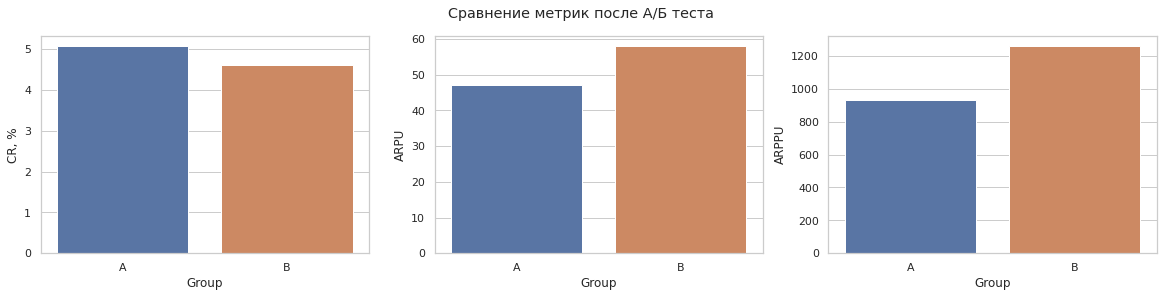

In [41]:
graphics(import_data(file_path))